In [1]:
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
from opensoundscape.torch.models import cnn
from opensoundscape.torch.architectures import cnn_architectures
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from opensoundscape.annotations import categorical_to_one_hot
import matplotlib.pyplot as plt
from opensoundscape.torch.models.cnn import load_model

# Reproduce Experiment Results Code

In [2]:

name = "autoamted_cosmos_tweety_to_file"
train_val_df = pd.read_csv(name + '_TRAINING.csv')
test_df = pd.read_csv(name + '_TESTING.csv')
test_df["filename"] = test_df["file"].apply(lambda x: x.split("/")[-1])
one_hot_labels, test_classes = categorical_to_one_hot(test_df[['MANUAL ID']].values)
test_df = pd.DataFrame(index=test_df['file'],data=one_hot_labels,columns=test_classes)

model_save = './model/' + name  + '_no_none_class/'
#RERUN
model = load_model(model_save + 'best.model')#'best.model')
#model_save
#torch.save(model.state_dict(), model_save + "model_backup.pt")
prediction_dataset = model.train_dataset.sample(n=0)
prediction_dataset.augmentation_off()
prediction_dataset.df = test_df

In [3]:
prediction_dataset.df = prediction_dataset.df[list(model.classes)]

In [4]:
list(model.classes)

['Xiphorhynchus guttatus',
 'Ramphastos tucanus',
 'Microcerculus marginatus',
 'Thraupis episcopus',
 'Turdus leucomelas',
 'Myioborus miniatus',
 'Tolmomyias sulphurescens',
 'Trogon viridis',
 'Zonotrichia capensis',
 'Celeus grammicus']

In [5]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset,
                                                                 binary_preds='single_target',
                                                                 batch_size=16,
                                                                 num_workers=6,
                                                                 activation_layer='softmax')

/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 288, using nperseg = 288
  .format(nperseg, input_length))
/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 104, using nperseg = 104
  .format(nperseg, input_length))


(6933, 10)


In [7]:
print(classification_report(valid_labels_df, valid_preds_df))

              precision    recall  f1-score   support

           0       0.38      0.76      0.51       327
           1       0.75      0.85      0.80       556
           2       0.48      0.84      0.61       601
           3       0.45      0.59      0.51       376
           4       0.84      0.75      0.80       622
           5       0.41      0.75      0.53       425
           6       0.58      0.64      0.61       577
           7       0.57      0.65      0.61       594
           8       0.53      0.81      0.64       547
           9       0.56      0.72      0.63       479

   micro avg       0.55      0.74      0.63      5104
   macro avg       0.56      0.74      0.62      5104
weighted avg       0.57      0.74      0.64      5104
 samples avg       0.55      0.55      0.55      5104



/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


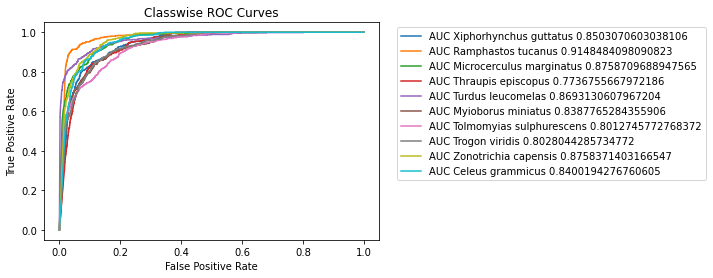

In [8]:
for species in model.classes:
    fpr, tpr, thresh = roc_curve(valid_labels_df[species],  valid_scores_df[species])
    auc = roc_auc_score(valid_labels_df[species],  valid_preds_df[species])
    plt.plot(fpr,tpr,label="AUC " + species + " "+str(auc))

plt.title('Classwise ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# Thresholding Code Testing

In [9]:
def thresholding(x, threshold=0.75):
    if (x >= threshold):
        return 1.0
    return 0.0
        

In [10]:
valid_scores_df.applymap(thresholding)

,Xiphorhynchus guttatus,Ramphastos tucanus,Microcerculus marginatus,Thraupis episcopus,Turdus leucomelas,Myioborus miniatus,Tolmomyias sulphurescens,Trogon viridis,Zonotrichia capensis,Celeus grammicus
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_0.0s_3.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_3.0s_6.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_6.0s_9.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_9.0s_9.299591836734693s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC101469 - Pale-breasted Thrush - Turdus leucomelas.mp3_0.0s_3.0s.wav,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC97542 - Slate-throated Whitestart - Myioborus miniatus.mp3_3.0s_4.362448979591837s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.mp3_0.0s_3.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.mp3_3.0s_6.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.mp3_6.0s_9.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
print("baseline: 50% thres")
print(classification_report(valid_labels_df, valid_preds_df))

baseline: 50% thres
              precision    recall  f1-score   support

           0       0.38      0.76      0.51       327
           1       0.75      0.85      0.80       556
           2       0.48      0.84      0.61       601
           3       0.45      0.59      0.51       376
           4       0.84      0.75      0.80       622
           5       0.41      0.75      0.53       425
           6       0.58      0.64      0.61       577
           7       0.57      0.65      0.61       594
           8       0.53      0.81      0.64       547
           9       0.56      0.72      0.63       479

   micro avg       0.55      0.74      0.63      5104
   macro avg       0.56      0.74      0.62      5104
weighted avg       0.57      0.74      0.64      5104
 samples avg       0.55      0.55      0.55      5104



/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
print("test1: 75% thres")
print(classification_report(valid_labels_df, valid_scores_df.applymap(thresholding)))

test1: 75% thres


/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.40      0.75      0.52       327
           1       0.75      0.85      0.80       556
           2       0.51      0.83      0.63       601
           3       0.46      0.56      0.51       376
           4       0.87      0.74      0.80       622
           5       0.43      0.73      0.54       425
           6       0.61      0.64      0.62       577
           7       0.59      0.62      0.60       594
           8       0.55      0.80      0.65       547
           9       0.58      0.71      0.63       479

   micro avg       0.57      0.73      0.64      5104
   macro avg       0.57      0.72      0.63      5104
weighted avg       0.59      0.73      0.64      5104
 samples avg       0.53      0.53      0.53      5104



/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
print("test1: 80% thres")
print(classification_report(valid_labels_df, valid_scores_df.applymap(thresholding, threshold=0.8)))

test1: 80% thres
              precision    recall  f1-score   support

           0       0.40      0.75      0.52       327
           1       0.75      0.85      0.80       556
           2       0.51      0.83      0.63       601
           3       0.47      0.56      0.51       376
           4       0.87      0.73      0.80       622
           5       0.43      0.73      0.54       425
           6       0.61      0.63      0.62       577
           7       0.59      0.61      0.60       594
           8       0.55      0.80      0.65       547
           9       0.58      0.70      0.64       479

   micro avg       0.57      0.72      0.64      5104
   macro avg       0.58      0.72      0.63      5104
weighted avg       0.60      0.72      0.64      5104
 samples avg       0.53      0.53      0.53      5104



/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
print("test1: 90% thres")
print(classification_report(valid_labels_df, valid_scores_df.applymap(thresholding, threshold=0.9)))

test1: 90% thres
              precision    recall  f1-score   support

           0       0.40      0.73      0.52       327
           1       0.76      0.85      0.80       556
           2       0.54      0.82      0.65       601
           3       0.47      0.55      0.51       376
           4       0.88      0.71      0.79       622
           5       0.45      0.72      0.55       425
           6       0.62      0.62      0.62       577
           7       0.61      0.59      0.60       594
           8       0.57      0.79      0.66       547
           9       0.59      0.68      0.63       479

   micro avg       0.58      0.71      0.64      5104
   macro avg       0.59      0.71      0.63      5104
weighted avg       0.61      0.71      0.65      5104
 samples avg       0.52      0.52      0.52      5104



/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
print("test1: 99% thres")
print(classification_report(valid_labels_df, valid_scores_df.applymap(thresholding, threshold=0.99)))

test1: 99% thres
              precision    recall  f1-score   support

           0       0.42      0.70      0.53       327
           1       0.76      0.85      0.80       556
           2       0.59      0.78      0.67       601
           3       0.48      0.50      0.49       376
           4       0.91      0.68      0.78       622
           5       0.49      0.70      0.57       425
           6       0.65      0.60      0.63       577
           7       0.68      0.55      0.61       594
           8       0.61      0.74      0.67       547
           9       0.59      0.64      0.61       479

   micro avg       0.62      0.68      0.65      5104
   macro avg       0.62      0.67      0.64      5104
weighted avg       0.64      0.68      0.65      5104
 samples avg       0.50      0.50      0.50      5104



/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:ylabel='Frequency'>

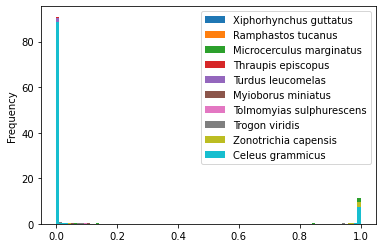

In [16]:
valid_scores_df.plot(kind="hist", density=True, bins=100)

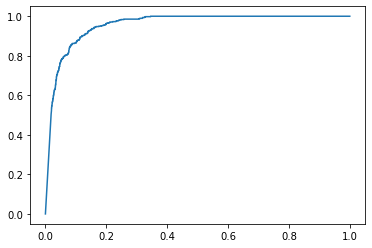

In [17]:
fpr, tpr, thresh = roc_curve(valid_labels_df[species],  valid_scores_df[species])
auc = roc_auc_score(valid_labels_df[species],  valid_preds_df[species])
plt.plot(fpr,tpr,label="AUC " + species + " "+str(auc))

0.066


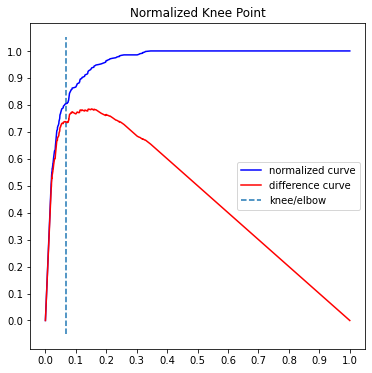

In [18]:
from kneed import KneeLocator
kneedle = KneeLocator(fpr, tpr, S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()

print(round(kneedle.elbow, 3))

In [19]:
result = np.where(fpr == kneedle.elbow)[0][0]
result

180

In [20]:
thresh[result]

0.0062344903

In [21]:
print("test1: ", thresh[result])
print(classification_report(valid_labels_df, valid_scores_df.applymap(thresholding, threshold=thresh[result])))

test1:  0.0062344903
              precision    recall  f1-score   support

           0       0.31      0.82      0.45       327
           1       0.74      0.87      0.80       556
           2       0.40      0.91      0.55       601
           3       0.41      0.70      0.51       376
           4       0.72      0.81      0.76       622
           5       0.33      0.82      0.47       425
           6       0.49      0.72      0.58       577
           7       0.46      0.76      0.58       594
           8       0.45      0.87      0.59       547
           9       0.47      0.80      0.60       479

   micro avg       0.46      0.81      0.59      5104
   macro avg       0.48      0.81      0.59      5104
weighted avg       0.49      0.81      0.60      5104
 samples avg       0.54      0.60      0.56      5104



/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
print("test1: ", 1-thresh[result])
print(classification_report(valid_labels_df, valid_scores_df.applymap(thresholding, threshold=1-thresh[result])))

test1:  0.9937655096873641
              precision    recall  f1-score   support

           0       0.43      0.69      0.53       327
           1       0.76      0.85      0.80       556
           2       0.61      0.78      0.69       601
           3       0.49      0.49      0.49       376
           4       0.92      0.67      0.77       622
           5       0.49      0.69      0.58       425
           6       0.65      0.60      0.63       577
           7       0.70      0.54      0.61       594
           8       0.63      0.74      0.68       547
           9       0.60      0.63      0.62       479

   micro avg       0.63      0.67      0.65      5104
   macro avg       0.63      0.67      0.64      5104
weighted avg       0.65      0.67      0.65      5104
 samples avg       0.50      0.50      0.50      5104



/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xiphorhynchus guttatus 0.9992472797748633
Ramphastos tucanus 0.9999952577873046


/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Microcerculus marginatus 0.15741658210754395
Thraupis episcopus 0.9999968012409681
Turdus leucomelas 0.9996367175190244
Myioborus miniatus 0.9960984487552196
Tolmomyias sulphurescens 0.9994503911584616
Trogon viridis 0.999856373964576
Zonotrichia capensis 0.9999022325646365
Celeus grammicus 0.9937655096873641
              precision    recall  f1-score   support

           0       0.45      0.68      0.54       327
           1       0.77      0.83      0.80       556
           2       0.45      0.86      0.59       601
           3       0.53      0.36      0.43       376
           4       0.95      0.62      0.75       622
           5       0.49      0.69      0.58       425
           6       0.69      0.58      0.63       577
           7       0.83      0.46      0.59       594
           8       0.67      0.68      0.68       547
           9       0.60      0.63      0.62       479

   micro avg       0.62      0.65      0.63      5104
   macro avg       0.64      0.64      

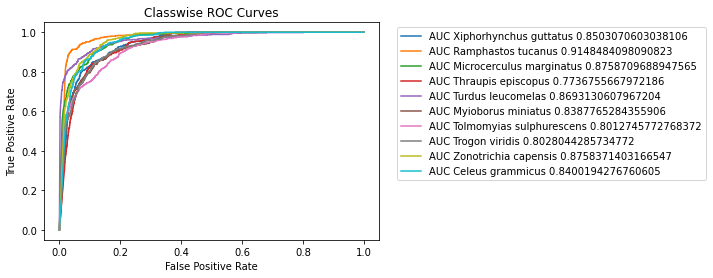

In [23]:
thresheld_labels_df = valid_scores_df.copy()
for species in model.classes:
    fpr, tpr, thresh = roc_curve(valid_labels_df[species],  valid_scores_df[species])
    auc = roc_auc_score(valid_labels_df[species],  valid_preds_df[species])
    plt.plot(fpr,tpr,label="AUC " + species + " "+str(auc))
    
    kneedle = KneeLocator(fpr, tpr, S=1.0, curve="concave", direction="increasing")
    result = np.where(fpr == kneedle.elbow)[0][0]
    threshold = 1-thresh[result]
    thresheld_labels_df[species] = thresheld_labels_df[species].apply(thresholding, threshold=threshold)
    print(species, threshold)
    
    
    
print(classification_report(valid_labels_df, thresheld_labels_df))




plt.title('Classwise ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [25]:
print(classification_report(valid_labels_df, valid_preds_df))

              precision    recall  f1-score   support

           0       0.38      0.76      0.51       327
           1       0.75      0.85      0.80       556
           2       0.48      0.84      0.61       601
           3       0.45      0.59      0.51       376
           4       0.84      0.75      0.80       622
           5       0.41      0.75      0.53       425
           6       0.58      0.64      0.61       577
           7       0.57      0.65      0.61       594
           8       0.53      0.81      0.64       547
           9       0.56      0.72      0.63       479

   micro avg       0.55      0.74      0.63      5104
   macro avg       0.56      0.74      0.62      5104
weighted avg       0.57      0.74      0.64      5104
 samples avg       0.55      0.55      0.55      5104



/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
valid_labels_df

,Xiphorhynchus guttatus,Ramphastos tucanus,Microcerculus marginatus,Thraupis episcopus,Turdus leucomelas,Myioborus miniatus,Tolmomyias sulphurescens,Trogon viridis,Zonotrichia capensis,Celeus grammicus
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_0.0s_3.0s.wav,0,0,0,0,0,0,0,0,1,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_3.0s_6.0s.wav,0,0,0,0,0,0,0,0,1,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_6.0s_9.0s.wav,0,0,0,0,0,0,0,0,1,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_9.0s_9.299591836734693s.wav,0,0,0,0,0,0,0,0,1,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC101469 - Pale-breasted Thrush - Turdus leucomelas.mp3_0.0s_3.0s.wav,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC97542 - Slate-throated Whitestart - Myioborus miniatus.mp3_3.0s_4.362448979591837s.wav,0,0,0,0,0,1,0,0,0,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.mp3_0.0s_3.0s.wav,0,0,0,0,0,0,0,0,1,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.mp3_3.0s_6.0s.wav,0,0,0,0,0,0,0,0,1,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.mp3_6.0s_9.0s.wav,0,0,0,0,0,0,0,0,1,0


<AxesSubplot:ylabel='Frequency'>

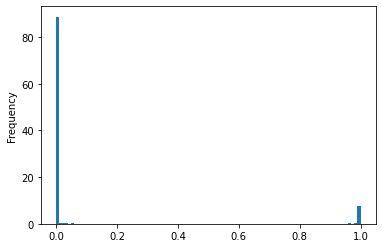

In [28]:
valid_scores_df[species].plot(kind="hist", density=True, bins=100)

# Visulizations For Presentation


In [48]:
print(classification_report(valid_labels_df, valid_preds_df))

              precision    recall  f1-score   support

           0       0.38      0.76      0.51       327
           1       0.75      0.85      0.80       556
           2       0.48      0.84      0.61       601
           3       0.45      0.59      0.51       376
           4       0.84      0.75      0.80       622
           5       0.41      0.75      0.53       425
           6       0.58      0.64      0.61       577
           7       0.57      0.65      0.61       594
           8       0.53      0.81      0.64       547
           9       0.56      0.72      0.63       479

   micro avg       0.55      0.74      0.63      5104
   macro avg       0.56      0.74      0.62      5104
weighted avg       0.57      0.74      0.64      5104
 samples avg       0.55      0.55      0.55      5104



/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
valid_labels_df

,Xiphorhynchus guttatus,Ramphastos tucanus,Microcerculus marginatus,Thraupis episcopus,Turdus leucomelas,Myioborus miniatus,Tolmomyias sulphurescens,Trogon viridis,Zonotrichia capensis,Celeus grammicus
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_0.0s_3.0s.wav,0,0,0,0,0,0,0,0,1,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_3.0s_6.0s.wav,0,0,0,0,0,0,0,0,1,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_6.0s_9.0s.wav,0,0,0,0,0,0,0,0,1,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_9.0s_9.299591836734693s.wav,0,0,0,0,0,0,0,0,1,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC101469 - Pale-breasted Thrush - Turdus leucomelas.mp3_0.0s_3.0s.wav,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC97542 - Slate-throated Whitestart - Myioborus miniatus.mp3_3.0s_4.362448979591837s.wav,0,0,0,0,0,1,0,0,0,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.mp3_0.0s_3.0s.wav,0,0,0,0,0,0,0,0,1,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.mp3_3.0s_6.0s.wav,0,0,0,0,0,0,0,0,1,0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.mp3_6.0s_9.0s.wav,0,0,0,0,0,0,0,0,1,0


In [33]:
valid_preds_df

,Xiphorhynchus guttatus,Ramphastos tucanus,Microcerculus marginatus,Thraupis episcopus,Turdus leucomelas,Myioborus miniatus,Tolmomyias sulphurescens,Trogon viridis,Zonotrichia capensis,Celeus grammicus
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_0.0s_3.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_3.0s_6.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_6.0s_9.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis.mp3_9.0s_9.299591836734693s.wav,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC101469 - Pale-breasted Thrush - Turdus leucomelas.mp3_0.0s_3.0s.wav,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC97542 - Slate-throated Whitestart - Myioborus miniatus.mp3_3.0s_4.362448979591837s.wav,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.mp3_0.0s_3.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.mp3_3.0s_6.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
./temp_clips/Cosmos_Data/Testing_Xeno_Canto_2022//XC9766 - Rufous-collared Sparrow - Zonotrichia capensis.mp3_6.0s_9.0s.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [37]:
valid_labels_df["Xiphorhynchus guttatus"].values

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [49]:
tp = sum ((valid_preds_df["Xiphorhynchus guttatus"].values + valid_labels_df["Xiphorhynchus guttatus"].values) == 2)
fp = sum ((valid_preds_df["Xiphorhynchus guttatus"].values - valid_labels_df["Xiphorhynchus guttatus"].values) == 1)
fn = sum ((valid_preds_df["Xiphorhynchus guttatus"].values - valid_labels_df["Xiphorhynchus guttatus"].values) == -1)
fp, tp, fn

(402, 249, 78)

In [50]:
percision = tp / (tp + fp)

In [51]:
recall = tp / (tp + fn)

In [54]:
percision, recall

(0.3824884792626728, 0.7614678899082569)

In [53]:
print(classification_report(valid_labels_df, valid_preds_df))

              precision    recall  f1-score   support

           0       0.38      0.76      0.51       327
           1       0.75      0.85      0.80       556
           2       0.48      0.84      0.61       601
           3       0.45      0.59      0.51       376
           4       0.84      0.75      0.80       622
           5       0.41      0.75      0.53       425
           6       0.58      0.64      0.61       577
           7       0.57      0.65      0.61       594
           8       0.53      0.81      0.64       547
           9       0.56      0.72      0.63       479

   micro avg       0.55      0.74      0.63      5104
   macro avg       0.56      0.74      0.62      5104
weighted avg       0.57      0.74      0.64      5104
 samples avg       0.55      0.55      0.55      5104



/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
#Actual loop
compare_precision  = pd.DataFrame(columns=valid_preds_df.columns)
compare_recall  = pd.DataFrame(columns=valid_preds_df.columns)
row_percision = {}
row_recall = {}

WTS_index = name

for species in valid_preds_df.columns:
    tp = sum ((valid_preds_df[species].values + valid_labels_df[species].values) == 2)
    fp = sum ((valid_preds_df[species].values - valid_labels_df[species].values) == 1)
    fn = sum ((valid_preds_df[species].values - valid_labels_df[species].values) == -1)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    row_percision[species] = precision
    row_recall[species] = recall
    
    
compare_precision.loc[WTS_index] = row_percision
compare_recall.loc[WTS_index] = row_recall
    


In [64]:
compare_precision

,Xiphorhynchus guttatus,Ramphastos tucanus,Microcerculus marginatus,Thraupis episcopus,Turdus leucomelas,Myioborus miniatus,Tolmomyias sulphurescens,Trogon viridis,Zonotrichia capensis,Celeus grammicus
autoamted_cosmos_tweety_to_file,0.382488,0.751582,0.478178,0.454733,0.843243,0.40874,0.58125,0.570796,0.529762,0.558966


In [65]:
compare_recall

,Xiphorhynchus guttatus,Ramphastos tucanus,Microcerculus marginatus,Thraupis episcopus,Turdus leucomelas,Myioborus miniatus,Tolmomyias sulphurescens,Trogon viridis,Zonotrichia capensis,Celeus grammicus
autoamted_cosmos_tweety_to_file,0.761468,0.854317,0.838602,0.587766,0.752412,0.748235,0.644714,0.651515,0.813528,0.722338


In [ ]:
name = "autoamted_cosmos_tweety_to_file"
main_name ="./" +name + ".csv"#"./COSMOS_Microfaune-Filename_Labels_100.csv"#"./COSMOS_BirdNET-Lite-Filename_Labels_05Conf.csv" #'./COSMOS_BirdNET-Lite_Labels_05Conf.csv' #Tweety birdnet, #tweetyfilename


In [72]:
names = [
        "autoamted_cosmos_tweety_to_file",
        "automated_cosmos_tweety_to_birdnet",  
        "COSMOS_BirdNET-Lite_Labels_05Conf",  
        "COSMOS_BirdNET-Lite-Filename_Labels_05Conf", 
        "COSMOS_BirdNET-Lite_Labels_100", 
        "COSMOS_Microfaune-Filename_Labels_100"
]

compare_precision  = pd.DataFrame(columns=valid_preds_df.columns)
compare_recall  = pd.DataFrame(columns=valid_preds_df.columns)
    
    
for name in names:
    train_val_df = pd.read_csv(name + '_TRAINING.csv')
    test_df = pd.read_csv(name + '_TESTING.csv')
    test_df["filename"] = test_df["file"].apply(lambda x: x.split("/")[-1])
    one_hot_labels, test_classes = categorical_to_one_hot(test_df[['MANUAL ID']].values)
    test_df = pd.DataFrame(index=test_df['file'],data=one_hot_labels,columns=test_classes)

    model_save = './model/' + name  + '_no_none_class/'
    #RERUN
    try:
        model = load_model(model_save + 'best.model')#'best.model')
    except:
        model = load_model(model_save + 'epoch-0.model')
        
    #model_save
    #torch.save(model.state_dict(), model_save + "model_backup.pt")
    prediction_dataset = model.train_dataset.sample(n=0)
    prediction_dataset.augmentation_off()
    prediction_dataset.df = test_df
    prediction_dataset.df = prediction_dataset.df[list(model.classes)]
    valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset,
                                                                 binary_preds='single_target',
                                                                 batch_size=16,
                                                                 num_workers=6,
                                                                 activation_layer='softmax')
    
    
    #Compute stats
    
    row_percision = {}
    row_recall = {}

    WTS_index = name

    for species in valid_preds_df.columns:
        tp = sum ((valid_preds_df[species].values + valid_labels_df[species].values) == 2)
        fp = sum ((valid_preds_df[species].values - valid_labels_df[species].values) == 1)
        fn = sum ((valid_preds_df[species].values - valid_labels_df[species].values) == -1)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        row_percision[species] = precision
        row_recall[species] = recall


    compare_precision.loc[WTS_index] = row_percision
    compare_recall.loc[WTS_index] = row_recall
    

compare_recall

/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 288, using nperseg = 288
  .format(nperseg, input_length))
/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 104, using nperseg = 104
  .format(nperseg, input_length))


(6933, 10)


/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 288, using nperseg = 288
  .format(nperseg, input_length))
/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 104, using nperseg = 104
  .format(nperseg, input_length))


(6933, 10)


/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 288, using nperseg = 288
  .format(nperseg, input_length))


(5912, 42)


/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 288, using nperseg = 288
  .format(nperseg, input_length))


(5912, 10)


/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 288, using nperseg = 288
  .format(nperseg, input_length))
/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 104, using nperseg = 104
  .format(nperseg, input_length))


(6933, 11)


/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 288, using nperseg = 288
  .format(nperseg, input_length))
/home/shperry/anaconda3/envs/species-id/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 104, using nperseg = 104
  .format(nperseg, input_length))


(6933, 10)


,Xiphorhynchus guttatus,Tolmomyias sulphurescens,Patagioenas subvinacea,Ramphastos vitellinus,Lipaugus vociferans,Thraupis episcopus,Xiphorhynchus susurrans,Myiarchus crinitus,Myiothlypis flaveola,Pipilo erythrophthalmus,...,Turdus merula,Zonotrichia capensis,Mimus gilvus,Setophaga dominica,Turdus leucomelas,Ramphastos tucanus,Trogon melanurus,Thraupis palmarum,Celeus undatus,Herpsilochmus rufimarginatus
autoamted_cosmos_tweety_to_file,0.596330,0.592721,NaN,NaN,NaN,0.755319,NaN,NaN,NaN,NaN,...,NaN,0.756856,NaN,NaN,0.771704,0.875899,NaN,NaN,NaN,NaN
automated_cosmos_tweety_to_birdnet,0.644068,0.514870,NaN,NaN,NaN,0.909091,NaN,NaN,NaN,NaN,...,NaN,0.685965,NaN,NaN,0.720000,0.855335,NaN,NaN,NaN,NaN
COSMOS_BirdNET-Lite_Labels_05Conf,0.647059,0.475138,0.0,0.0,1.000000,0.573265,0.923077,0.0,0.0,0.0,...,0.0,0.713755,0.0,0.045455,0.537267,0.791849,0.0,0.0,0.107143,0.0
COSMOS_BirdNET-Lite-Filename_Labels_05Conf,0.072072,0.000000,NaN,NaN,NaN,0.001792,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,0.122581,0.000000,NaN,NaN,NaN,NaN
COSMOS_BirdNET-Lite_Labels_100,0.759162,0.527928,NaN,NaN,0.777778,0.662088,NaN,NaN,NaN,NaN,...,NaN,0.769231,NaN,NaN,0.698492,0.814882,NaN,NaN,NaN,NaN
COSMOS_Microfaune-Filename_Labels_100,0.703196,0.589178,NaN,NaN,NaN,0.504065,NaN,NaN,NaN,NaN,...,NaN,0.763158,NaN,NaN,0.732773,0.839937,NaN,NaN,NaN,NaN


In [73]:
compare_precision

,Xiphorhynchus guttatus,Tolmomyias sulphurescens,Patagioenas subvinacea,Ramphastos vitellinus,Lipaugus vociferans,Thraupis episcopus,Xiphorhynchus susurrans,Myiarchus crinitus,Myiothlypis flaveola,Pipilo erythrophthalmus,...,Turdus merula,Zonotrichia capensis,Mimus gilvus,Setophaga dominica,Turdus leucomelas,Ramphastos tucanus,Trogon melanurus,Thraupis palmarum,Celeus undatus,Herpsilochmus rufimarginatus
autoamted_cosmos_tweety_to_file,0.355191,0.620690,NaN,NaN,NaN,0.390646,NaN,NaN,NaN,NaN,...,NaN,0.554217,NaN,NaN,0.704846,0.733434,NaN,NaN,NaN,NaN
automated_cosmos_tweety_to_birdnet,0.478417,0.659524,NaN,NaN,NaN,0.296774,NaN,NaN,NaN,NaN,...,NaN,0.507134,NaN,NaN,0.602410,0.746057,NaN,NaN,NaN,NaN
COSMOS_BirdNET-Lite_Labels_05Conf,0.363276,0.583051,0.0,0.0,0.375000,0.529691,0.674157,0.0,0.0,0.0,...,0.0,0.534819,0.0,0.018519,0.321561,0.909699,0.0,0.0,0.130435,0.0
COSMOS_BirdNET-Lite-Filename_Labels_05Conf,0.571429,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.504425,NaN,NaN,NaN,NaN,NaN
COSMOS_BirdNET-Lite_Labels_100,0.308183,0.478758,NaN,NaN,0.179487,0.338959,NaN,NaN,NaN,NaN,...,NaN,0.505920,NaN,NaN,0.468539,0.689708,NaN,NaN,NaN,NaN
COSMOS_Microfaune-Filename_Labels_100,0.373333,0.410042,NaN,NaN,NaN,0.378819,NaN,NaN,NaN,NaN,...,NaN,0.506993,NaN,NaN,0.481236,0.732044,NaN,NaN,NaN,NaN


In [76]:



compare_recall = compare_recall[["Xiphorhynchus guttatus", "Ramphastos tucanus", "Microcerculus marginatus", "Thraupis episcopus", "Turdus leucomelas", "Myioborus miniatus", "Tolmomyias sulphurescens", "Trogon viridis", "Zonotrichia capensis", "Celeus grammicus"]]

In [75]:
compare_precision = compare_precision[["Xiphorhynchus guttatus", "Ramphastos tucanus", "Microcerculus marginatus", "Thraupis episcopus", "Turdus leucomelas", "Myioborus miniatus", "Tolmomyias sulphurescens", "Trogon viridis", "Zonotrichia capensis", "Celeus grammicus"]]

In [79]:
compare_recall.to_csv("recall_stats.csv")

In [80]:
compare_precision.to_csv("precision_stats.csv")